In [1]:
# !pip uninstall numpy -y
# !pip install "numpy==1.24.4" pandas matplotlib seaborn spacy==3.8.5 nltk scipy --no-deps
# !python -m spacy download en_core_web_sm


In [2]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import scipy
# import spacy
# import nltk
# import re

# nltk.download("punkt")
# nltk.download("stopwords")
# nltk.download("wordnet")
# nltk.download("vader_lexicon")

# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.sentiment.vader import SentimentIntensityAnalyzer

# nlp = spacy.load("en_core_web_sm")
# sia = SentimentIntensityAnalyzer()


In [3]:
# Core libraries
import pandas as pd
import numpy as np
import re

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
import nltk
import spacy

# Ensure NLTK data is downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

# NLTK imports
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Optional: Set Seaborn visualization style
sns.set(style="whitegrid", palette="viridis")


/Users/ariankalantari/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ariankalantari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ariankalantari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ariankalantari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ariankalantari/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Exploratory Data Analysis

We first need to explore the dataset to find some patterns or some improvements we could possibly make when manupilating the data. This will help us work with appropreately cleaned data, and dive deeper to extract insights.

## Loading Dataset

We now have scraped reviews for British Airway from https://www.airlinequality.com/. The data is now available in data folder to perform further data analysis.
Our dataset contains 3925 datapoints, and below listed are the column names:

- posted_date 
- is_verified
- comment
- aircraft
- traveller_type
- cabin_class
- route
- flight_date
- seat_comfort_rating
- cabin_staff_service_rating
- food_and_beverages_rating
- inflight_entertainment_rating
- ground_service_rating
- wifi_and_connectivity_rating
- value_for_money_rating
- is_recommended

In [4]:
df = pd.read_csv('data/scraped_data.csv')
len(df)

3925

In [5]:
df[0:4]

,posted_date,is_verified,comment,aircraft,traveller_type,cabin_class,route,flight_date,seat_comfort_rating,cabin_staff_service_rating,food_and_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_and_connectivity_rating,value_for_money_rating,is_recommended
0,2025-03-31,Not Verified,Not Verified| Very good service on this route...,A320,Couple Leisure,Business Class,London Gatwick to Fuerteventura,March 2025,4.0,5.0,5.0,NaN,4.0,NaN,4.0,yes
1,2025-03-19,Trip Verified,✅Trip Verified| Flight mainly let down by a ...,Boeing 787,Solo Leisure,Business Class,Cape Town to London,March 2025,5.0,2.0,5.0,5.0,4.0,1.0,4.0,yes
2,2025-03-16,Trip Verified,✅Trip Verified| Another awful experience by ...,NaN,Business,Business Class,London to Geneva,December 2024,1.0,1.0,NaN,NaN,1.0,NaN,1.0,no
3,2025-03-16,Trip Verified,"✅Trip Verified| The service was rude, full o...",NaN,Business,Premium Economy,London to New York,January 2025,1.0,1.0,1.0,NaN,5.0,NaN,1.0,no


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3925 entries, 0 to 3924
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   posted_date                    3925 non-null   object 
 1   is_verified                    1611 non-null   object 
 2   comment                        3925 non-null   object 
 3   aircraft                       2045 non-null   object 
 4   traveller_type                 3154 non-null   object 
 5   cabin_class                    3923 non-null   object 
 6   route                          3149 non-null   object 
 7   flight_date                    3147 non-null   object 
 8   seat_comfort_rating            3798 non-null   float64
 9   cabin_staff_service_rating     3783 non-null   float64
 10  food_and_beverages_rating      3485 non-null   float64
 11  inflight_entertainment_rating  2670 non-null   float64
 12  ground_service_rating          3075 non-null   f

## Cleaning

From the look of the dataset, we can see some possibility of improvements:

- route can be divided into departing_location and arrival_location and via_information.
- is_verified could be binary (yes = 1, no = 0)
- is_recommended could be binary (yes = 1, no = 0)
- There seems to be many missing values in aircraft and some ratings. (We will handle this later.)

We can first make some data manupilation on above. Let's get started.

In [7]:
# Dividing route into departure, arrival and via.
departures = []
arrivals = []
vias = []

def parse_route(route):
    if not isinstance(route, str):
        departures.append(None)
        arrivals.append(None)
        vias.append(None)
        return
    
    # Case 1: With via
    if 'via' in route:
        pattern = r'^(.*) to (.*) via (.*)$'
        match = re.match(pattern, route)
        if match:
            departure, arrival, via = match.groups()
            departures.append(departure.strip())
            arrivals.append(arrival.strip())
            vias.append(via.strip())
            return
    
    # Case 2: Direct
    elif 'to' in route:
        pattern = r'^(.*) to (.*)$'
        match = re.match(pattern, route)
        if match:
            departure, arrival = match.groups()
            departures.append(departure.strip())
            arrivals.append(arrival.strip())
            vias.append(None)
            return
    
    # Case 3: Unrecognizable format
    departures.append(None)
    arrivals.append(None)
    vias.append(None)

for route in df.route:
    parse_route(route)

df["departure"] = departures
df["arrivals"] = arrivals
df["via"] = vias

In [8]:
# Converting is_verified into binary value.
df.is_verified = df.is_verified.fillna(0)
df.is_verified = np.where(df['is_verified'] == 'Trip Verified', 1, 0)

# Converting is_recommended into binary value.
df.is_recommended = np.where(df['is_recommended'] == 'yes', 1, 0)
df.is_recommended

0       1
1       1
2       0
3       0
4       0
       ..
3920    1
3921    1
3922    1
3923    0
3924    0
Name: is_recommended, Length: 3925, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3925 entries, 0 to 3924
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   posted_date                    3925 non-null   object 
 1   is_verified                    3925 non-null   int64  
 2   comment                        3925 non-null   object 
 3   aircraft                       2045 non-null   object 
 4   traveller_type                 3154 non-null   object 
 5   cabin_class                    3923 non-null   object 
 6   route                          3149 non-null   object 
 7   flight_date                    3147 non-null   object 
 8   seat_comfort_rating            3798 non-null   float64
 9   cabin_staff_service_rating     3783 non-null   float64
 10  food_and_beverages_rating      3485 non-null   float64
 11  inflight_entertainment_rating  2670 non-null   float64
 12  ground_service_rating          3075 non-null   f

**There seems to be many missing values in below columns:**

- aircraft (roughly 2000)
- traveller_type (roughly 800)
- cabin_class (2)
- route (roughly 800)
- flight_date (roughly 800)
- seat_comfort_rating (roughly 200)
- cabin_staff_service_rating (roughly 800)
- food_and_beverages_rating (roughly 500)
- inflight_entertainment_rating (roughly 1400)
- ground_service_rating (roughly 900)
- wifi_and_connectivity_rating (roughly 3300)
- value_for_money_rating (1) 

We can compute the percentage of missing values per column below:

In [10]:
for col in df.columns:
    ratio = df[col].isnull().sum()/len(df)
    ratio = round(ratio,2) * 100
    print(f"{col}: {ratio}%")

posted_date: 0.0%
is_verified: 0.0%
comment: 0.0%
aircraft: 48.0%
traveller_type: 20.0%
cabin_class: 0.0%
route: 20.0%
flight_date: 20.0%
seat_comfort_rating: 3.0%
cabin_staff_service_rating: 4.0%
food_and_beverages_rating: 11.0%
inflight_entertainment_rating: 32.0%
ground_service_rating: 22.0%
wifi_and_connectivity_rating: 82.0%
value_for_money_rating: 0.0%
is_recommended: 0.0%
departure: 20.0%
arrivals: 20.0%
via: 86.0%


In [11]:
# Check what the rows with traveller_type missing value.
traveller_null = df[df["traveller_type"].isnull()]

traveller_null.info()

<class 'pandas.core.frame.DataFrame'>
Index: 771 entries, 287 to 3924
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   posted_date                    771 non-null    object 
 1   is_verified                    771 non-null    int64  
 2   comment                        771 non-null    object 
 3   aircraft                       1 non-null      object 
 4   traveller_type                 0 non-null      object 
 5   cabin_class                    770 non-null    object 
 6   route                          3 non-null      object 
 7   flight_date                    3 non-null      object 
 8   seat_comfort_rating            769 non-null    float64
 9   cabin_staff_service_rating     769 non-null    float64
 10  food_and_beverages_rating      768 non-null    float64
 11  inflight_entertainment_rating  759 non-null    float64
 12  ground_service_rating          2 non-null      float

From the above we can tell that there are 771 datapoints missing travveler_type, but still carries useful information such as comments and ratings for us to deep dive into. As such, we will keep the records rather than dropping them whist cleaning the data.

There are 2 x ways to fill these missing values in traveller_type column. One is using mode (frequent value) and the other is using random vaslue based on exisiting value (traveller_type distribution), and this time we are going for simpler imputation option, that is replacing NaN with mode.

**Note that this imputation could be biased as we are not introducing any randomness, however in the sense of replication, this is better and easier option.**

<Axes: title={'center': 'Traveller Type Distribution'}, xlabel='traveller_type'>

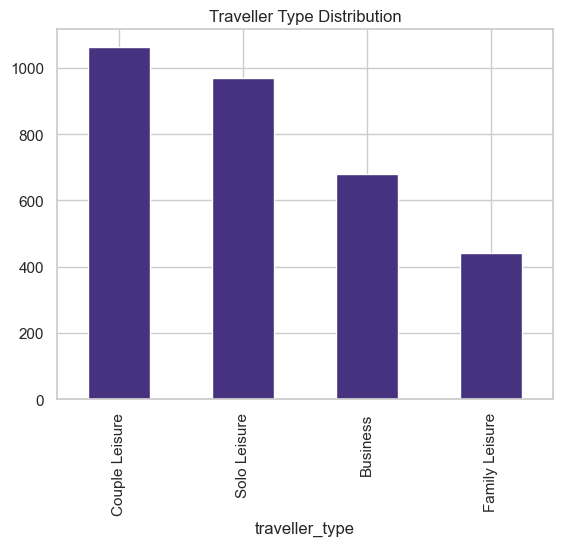

In [12]:
# Before Replacing with Mode
df['traveller_type'].value_counts().plot(kind='bar', title='Traveller Type Distribution')

In [13]:
traveller_type_mode = df.traveller_type.mode()[0]
traveller_type_mode

df.traveller_type = df.traveller_type.fillna(traveller_type_mode)

<Axes: title={'center': 'Traveller Type Distribution'}, xlabel='traveller_type'>

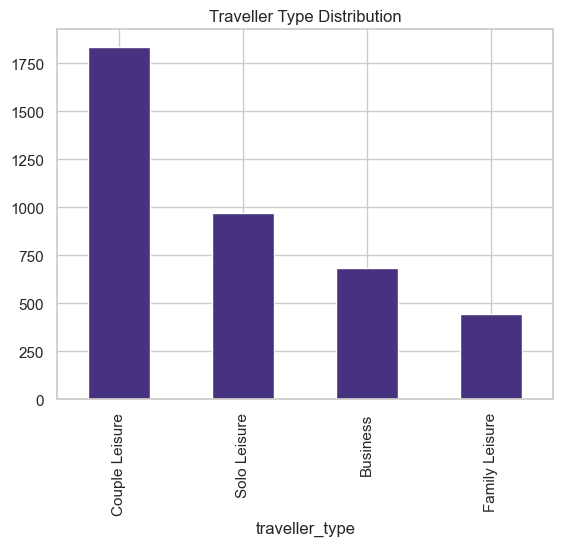

In [14]:
# print(df.traveller_type.unique())

df['traveller_type'].value_counts().plot(kind='bar', title='Traveller Type Distribution')

Now let's move onto ratings. We have to decide if filling those missing values make sense or not. 

1. seat_comfort_rating, cabin_staff_service_rating can be filled with the median rate.
3. 


In [15]:
# Replacing NaN for seat_comfort_rating, cabin_staff_service_rating with median rate.
seat_comfort_rating_median = df.seat_comfort_rating.median()
cabin_staff_service_rating_median = df.cabin_staff_service_rating.median()

df.seat_comfort_rating = df.seat_comfort_rating.fillna(seat_comfort_rating_median)
df.cabin_staff_service_rating = df.cabin_staff_service_rating.fillna(cabin_staff_service_rating_median)

print(df.seat_comfort_rating.isnull().sum())
print(df.cabin_staff_service_rating.isnull().sum())

0
0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3925 entries, 0 to 3924
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   posted_date                    3925 non-null   object 
 1   is_verified                    3925 non-null   int64  
 2   comment                        3925 non-null   object 
 3   aircraft                       2045 non-null   object 
 4   traveller_type                 3925 non-null   object 
 5   cabin_class                    3923 non-null   object 
 6   route                          3149 non-null   object 
 7   flight_date                    3147 non-null   object 
 8   seat_comfort_rating            3925 non-null   float64
 9   cabin_staff_service_rating     3925 non-null   float64
 10  food_and_beverages_rating      3485 non-null   float64
 11  inflight_entertainment_rating  2670 non-null   float64
 12  ground_service_rating          3075 non-null   f

Let's move down to next missing values such as cabin_class and all ratings. Based on above we can say that:

- **cabin_class** missing values can be filled with mode.
- missing **route** can remain "Unknown", however, maybe we can fill this by reading comments.
- missing **flight_date** can be ignored here as we have an assumption of **posted_date** being close to the flight date.
- **food_and_beverages_rating** needs a closer look (missing roughly 450 data.)
- **inflight_entertainment_rating** needs a better examination (missing over 1000 data.)
- **ground_service_rating** needs a better examination (missing just under 1000 data.)
- **wifi_and_connectivity_rating** needs to be examined as its missing more than 3000 data.
- missing **value_for_money_rating** can be filled with mode.

In [17]:
# Replacing missing cabin class with mode
df['cabin_class'] = df['cabin_class'].fillna(df['cabin_class'].mode()[0])
cabin_class_null = df.cabin_class.isnull().sum()
print(f"Cabin Class Null: {cabin_class_null}")


# Replacing missing aircraft with Unknown
df.aircraft = df.aircraft.fillna("Unknown")
aircraft_null = df.aircraft.isnull().sum()
print(f"Aircraft Null: {aircraft_null}")


# Replacing missing flight date with Unknown
df.flight_date = df.flight_date.fillna("Unknown")
flight_date_null = df.flight_date.isnull().sum()
print(f"Flight Date Null: {flight_date_null}")


# Replacing missing route with Unknown
df.route = df.route.fillna("Unknown")
route_null = df.route.isnull().sum()
print(f"Route Null: {route_null}")

Cabin Class Null: 0
Aircraft Null: 0
Flight Date Null: 0
Route Null: 0


In [18]:
df[['cabin_class', 'aircraft', 'flight_date', 'route']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3925 entries, 0 to 3924
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cabin_class  3925 non-null   object
 1   aircraft     3925 non-null   object
 2   flight_date  3925 non-null   object
 3   route        3925 non-null   object
dtypes: object(4)
memory usage: 122.8+ KB


Now before moving to the next, let's work on flight_date and posted_date to extract more meaningful information such as year to validate our point in some of the missing ratings are due to questionaire update or service availability.

We first need to see if it makes sense to replace the missing flight_date with posted_date as we have an assumption of those 2 dates are close to each other. We can work on this after extracting year from these dates.

In [19]:
# flight_date has a certain format so we can target what we want.
df['flight_date_parsed'] = pd.to_datetime(df['flight_date'], format='%B %Y', errors='coerce')
df['flight_year'] = df['flight_date_parsed'].dt.year
df['flight_month'] = df['flight_date_parsed'].dt.month_name()

# Same as above, but the format is different.
df['posted_date_parsed'] = pd.to_datetime(df['posted_date'], format='%Y-%m-%d', errors='coerce')
df['posted_year'] = df['posted_date_parsed'].dt.year

In [20]:
df.head(3)

,posted_date,is_verified,comment,aircraft,traveller_type,cabin_class,route,flight_date,seat_comfort_rating,cabin_staff_service_rating,...,value_for_money_rating,is_recommended,departure,arrivals,via,flight_date_parsed,flight_year,flight_month,posted_date_parsed,posted_year
0,2025-03-31,0,Not Verified| Very good service on this route...,A320,Couple Leisure,Business Class,London Gatwick to Fuerteventura,March 2025,4.0,5.0,...,4.0,1,London Gatwick,Fuerteventura,None,2025-03-01,2025.0,March,2025-03-31,2025
1,2025-03-19,1,✅Trip Verified| Flight mainly let down by a ...,Boeing 787,Solo Leisure,Business Class,Cape Town to London,March 2025,5.0,2.0,...,4.0,1,Cape Town,London,None,2025-03-01,2025.0,March,2025-03-19,2025
2,2025-03-16,1,✅Trip Verified| Another awful experience by ...,Unknown,Business,Business Class,London to Geneva,December 2024,1.0,1.0,...,1.0,0,London,Geneva,None,2024-12-01,2024.0,December,2025-03-16,2025


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3925 entries, 0 to 3924
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   posted_date                    3925 non-null   object        
 1   is_verified                    3925 non-null   int64         
 2   comment                        3925 non-null   object        
 3   aircraft                       3925 non-null   object        
 4   traveller_type                 3925 non-null   object        
 5   cabin_class                    3925 non-null   object        
 6   route                          3925 non-null   object        
 7   flight_date                    3925 non-null   object        
 8   seat_comfort_rating            3925 non-null   float64       
 9   cabin_staff_service_rating     3925 non-null   float64       
 10  food_and_beverages_rating      3485 non-null   float64       
 11  inflight_entertai

In [22]:
df_years = df[['posted_year', 'flight_year']]
df_years['diff'] = df_years.posted_year - df_years.flight_year

years_matched = sum(df_years.posted_year == df_years.flight_year)
print(f"Years are matching: {years_matched}")

df_years_not_matched = df_years[df_years.posted_year != df_years.flight_year]

Years are matching: 2944


/var/folders/kz/6m7_hvb57d9g_8cyxqcxs5580000gn/T/ipykernel_9580/2568210858.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_years['diff'] = df_years.posted_year - df_years.flight_year


In [23]:
df_years_not_matched.describe()

,posted_year,flight_year,diff
count,981.000000,203.000000,203.000000
mean,2015.278287,2017.881773,1.004926
std,2.302401,2.787137,0.070186
min,2011.000000,2014.000000,1.000000
25%,2014.000000,2016.000000,1.000000
50%,2015.000000,2017.000000,1.000000
75%,2015.000000,2019.000000,1.000000
max,2025.000000,2024.000000,2.000000


In [24]:
df_years[(df_years.posted_year != df_years.flight_year) & (df_years.flight_year.notnull())]

,posted_year,flight_year,diff
2,2025,2024.0,1.0
9,2025,2024.0,1.0
12,2025,2024.0,1.0
16,2025,2024.0,1.0
17,2025,2024.0,1.0
...,...,...,...
3105,2015,2014.0,1.0
3116,2015,2014.0,1.0
3119,2015,2014.0,1.0
3120,2015,2014.0,1.0


Let's talk about flight_year. We can see that there are about 20% datapoints missing, and dropping these many rows is not good. As most reviews are written soon after flying, we could use posted_year as a reliable proxy.

Now using this posted_year we can carry out time series analysis on missing ratings to see if those are because of service availability or questionare update.


***We can use posted_year to fill the year or use posted_year to carry out time series analysis.
There is only 5% (0.051719745222929936) of rows not having the same year, most of them are ok! (75% are matching)
20% are not matching due to flight_date missing.***

***We can clearly see that the difference is just 1 year for most of them when the years are compared.***


Some ratings are still missing values ranging from 500 to 1300. we need to check if that is because the rating review was introduced after certain year or is because the service availability.
Let's plot them.

In [25]:
def plot_missingness_by_year(df, column, date_col='posted_year'):
    missing_by_year = (
        df.groupby(date_col)[column]
        .apply(lambda x: x.isna().mean() * 100)
        .sort_index()
    )

    plt.figure(figsize=(10, 5))
    missing_by_year.plot(kind='bar', title=f"% Missing '{column}' by {date_col}", ylabel='% Missing', xlabel='Year')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

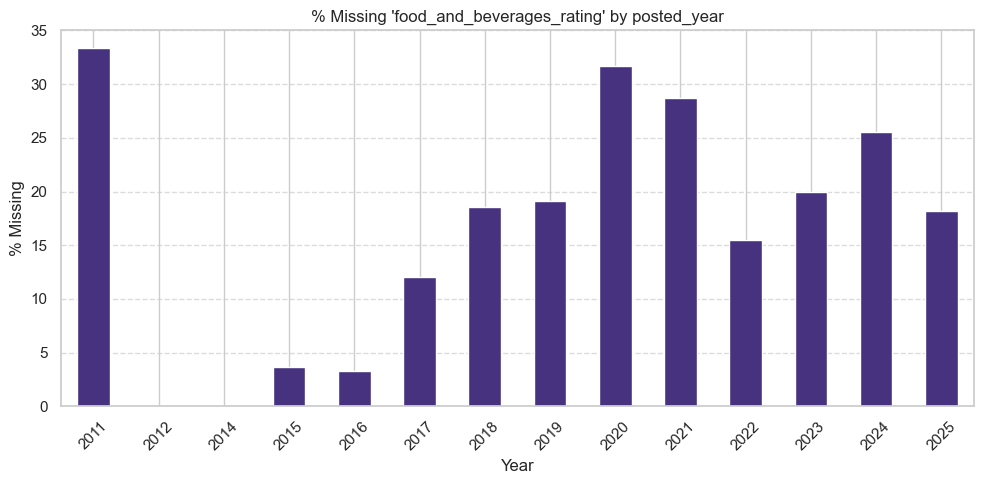

In [26]:
plot_missingness_by_year(df, 'food_and_beverages_rating')

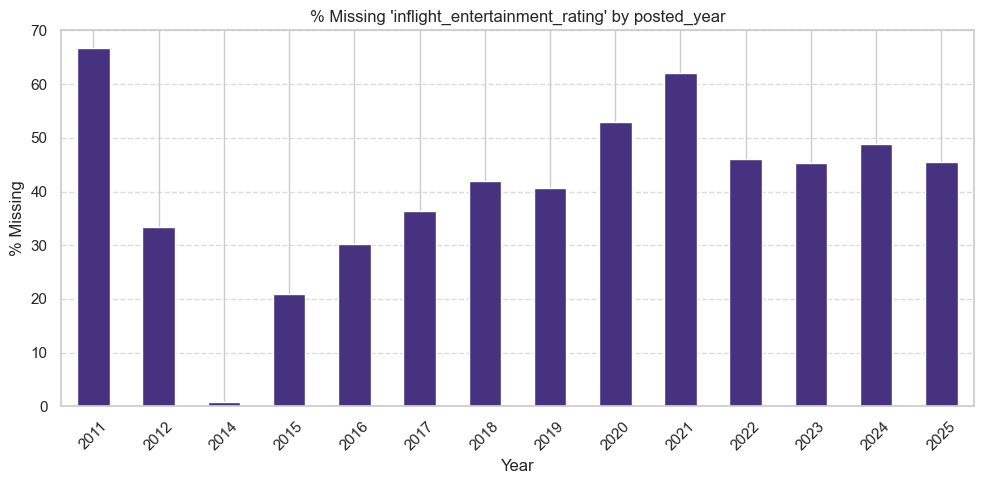

In [27]:
plot_missingness_by_year(df, 'inflight_entertainment_rating')

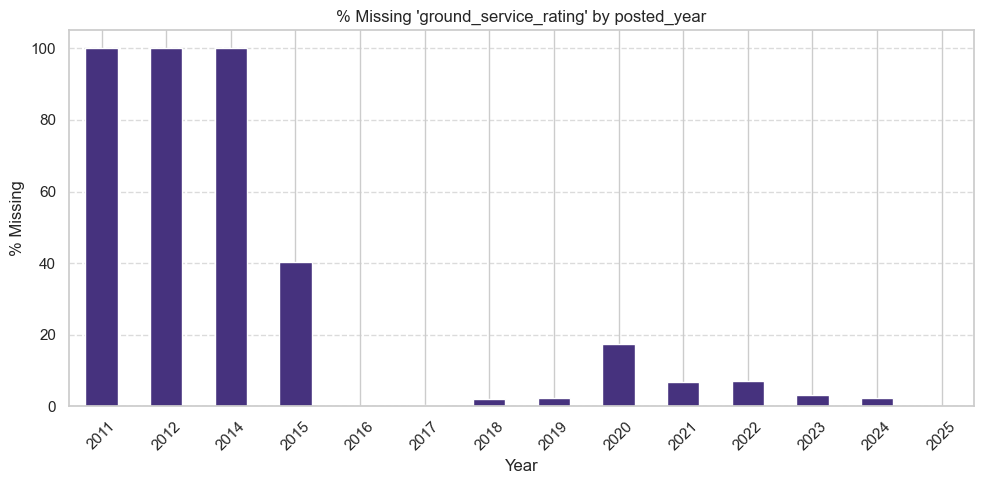

In [28]:
plot_missingness_by_year(df, 'ground_service_rating')

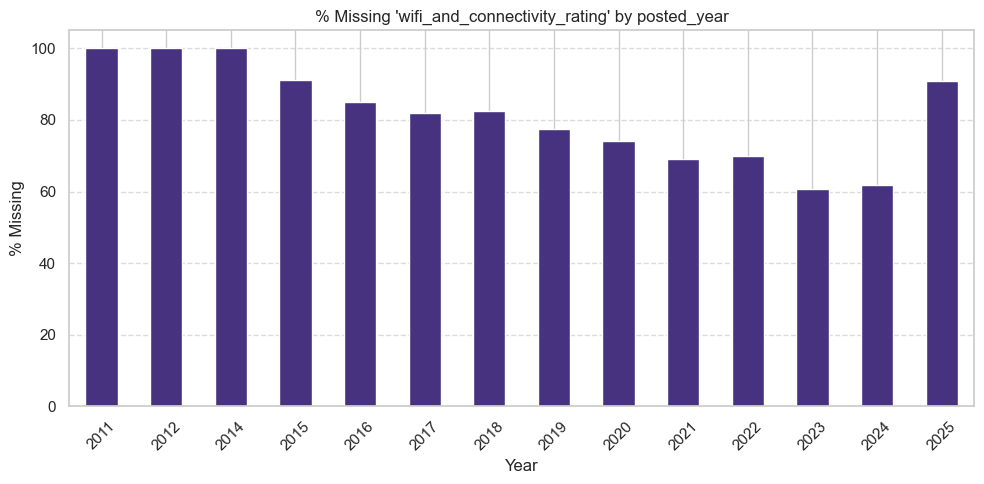

In [29]:
plot_missingness_by_year(df, 'wifi_and_connectivity_rating')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3925 entries, 0 to 3924
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   posted_date                    3925 non-null   object        
 1   is_verified                    3925 non-null   int64         
 2   comment                        3925 non-null   object        
 3   aircraft                       3925 non-null   object        
 4   traveller_type                 3925 non-null   object        
 5   cabin_class                    3925 non-null   object        
 6   route                          3925 non-null   object        
 7   flight_date                    3925 non-null   object        
 8   seat_comfort_rating            3925 non-null   float64       
 9   cabin_staff_service_rating     3925 non-null   float64       
 10  food_and_beverages_rating      3485 non-null   float64       
 11  inflight_entertai

In [31]:
df.groupby(["posted_year"])['posted_date'].count()

posted_year
2011      3
2012     12
2014    468
2015    738
2016    570
2017    572
2018    324
2019    356
2020    104
2021     87
2022    213
2023    280
2024    176
2025     22
Name: posted_date, dtype: int64

**We can assume that:**

- Number of customer reviews before 2014 are so small compared to other years.
- There is a sudden drop in numbers around 2020-2021 (COVID)
- ground_service_rating was not included in the survey before mid 2015.
- Wifi was simply not available for all customers. That is why there are many missing datapoints.
- food_and_beverages_rating missing values are scattered around all years.

In [32]:
# Replace value_for_money_rating missing value with 3
value_for_money_rating_median = df.value_for_money_rating.median()
df.value_for_money_rating = df.value_for_money_rating.fillna(value_for_money_rating_median)

df.value_for_money_rating.isnull().sum()

0

In [33]:
df.departure = df.departure.fillna("Unknown")
df.arrivals = df.arrivals.fillna("Unknown")
df.via = df.via.fillna("N/A")

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3925 entries, 0 to 3924
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   posted_date                    3925 non-null   object        
 1   is_verified                    3925 non-null   int64         
 2   comment                        3925 non-null   object        
 3   aircraft                       3925 non-null   object        
 4   traveller_type                 3925 non-null   object        
 5   cabin_class                    3925 non-null   object        
 6   route                          3925 non-null   object        
 7   flight_date                    3925 non-null   object        
 8   seat_comfort_rating            3925 non-null   float64       
 9   cabin_staff_service_rating     3925 non-null   float64       
 10  food_and_beverages_rating      3485 non-null   float64       
 11  inflight_entertai

df.info()

In [35]:
df.groupby(["cabin_class"], )[
    ['seat_comfort_rating',
     'cabin_staff_service_rating',
     'food_and_beverages_rating',
     'inflight_entertainment_rating',
     'ground_service_rating',
     'wifi_and_connectivity_rating',
     'value_for_money_rating',
     'is_recommended']
].mean().reset_index()

,cabin_class,seat_comfort_rating,cabin_staff_service_rating,food_and_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_and_connectivity_rating,value_for_money_rating,is_recommended
0,Business Class,2.908307,3.422414,2.950454,2.712838,2.913721,2.097345,2.754702,0.456113
1,Economy Class,2.720215,3.042480,2.470381,2.501207,2.599759,1.766571,2.562988,0.352051
2,First Class,3.674312,3.917431,3.247664,3.105000,3.166667,2.023810,3.059633,0.495413
3,Premium Economy,3.031332,3.127937,2.692958,2.808260,2.890411,2.219178,2.655352,0.404700


When inspecting missing values on ground_service_rating column, we can see that the data is missing for years before 2015. This could be due to the questionaire not including this rating for those years, and having the rating available for customers now.



## Review Pre-Processing

In [36]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [37]:
def preprocess_text(text):
    if pd.isnull(text):
        return ""

    # Lowercase
    text = text.lower()
    
    # Remove punctuation, numbers, and special characters
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize
    words = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    clean_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return " ".join(clean_words)


In [38]:
df['clean_comment'] = df['comment'].apply(preprocess_text)
df[['comment', 'clean_comment']].sample(5)

,comment,clean_comment
3680,Travelled as a family of four to the Maldives....,travelled family four maldives despite numerou...
3538,Sunday 2/11 Dublin to Heathrow. Flight arrived...,sunday dublin heathrow flight arrived late dep...
834,Not Verified| Gatwick to Malaga. Nothing spec...,verified gatwick malaga nothing special nowada...
3812,Recently travelled LHR to San Francisco and re...,recently travelled lhr san francisco returned ...
3597,I travelled to Hong Kong with British Airways ...,travelled hong kong british airway heathrow ou...


In [39]:
# Based on the abo e output, we decided to trim a little bit less 
# leaving more information in the review for better classification using Spacy!
def spacy_preprocess(text):
    if pd.isnull(text):
        return ""

    doc = nlp(text)

    tokens = []
    for token in doc:
        if (
            not token.is_punct
            and not token.is_space
            and not token.like_num
        ):
            # Preserve negation, named entities, and nouns/adjectives/verbs
            if token.is_stop and token.lower_ not in {"not", "no"}:
                continue
            tokens.append(token.lemma_.lower())
    
    return " ".join(tokens)

In [40]:
df['spacy_comment'] = df['comment'].apply(spacy_preprocess)
df[['comment', 'clean_comment', 'spacy_comment']].sample(5)

,comment,clean_comment,spacy_comment
3690,Economy class on 28 Aug from London (LHR) to N...,economy class aug london lhr new york jfk boar...,economy class aug london lhr new york jfk boar...
1679,✅Verified Review| BA used to be a nice airline...,verified review ba used nice airline great cus...,✅ verified review| ba nice airline great custo...
2676,Club class on British Airways between Cape Tow...,club class british airway cape town london boe...,club class british airways cape town london bo...
1707,✅Verified Review| I had a return flight to Is...,verified review return flight istanbul club eu...,✅ verified review| return flight istanbul club...
2500,Gatwick to Funchal. What has happened to BA cl...,gatwick funchal happened ba club europe used g...,gatwick funchal happen ba club europe wide sea...


In [41]:
# Having seen the output, we are djusting the output further (removing verified/not verified from review)
def remove_verified_tag(text):
    if not isinstance(text, str):
        return ""
    return re.sub(r"(✅\s*trip verified\|?|trip verified\|?|verified review\|?|not verified\|?)", "", text, flags=re.IGNORECASE).strip()

df['spacy_comment'] = df['spacy_comment'].apply(remove_verified_tag)
df[['spacy_comment']]

,spacy_comment
0,good service route ba2710 march cabin crew wor...
1,flight mainly let disagreeable flight attendan...
2,awful experience british airways flight delay ...
3,service rude attitude food poorly service cabi...
4,flight joke people business class include comp...
...,...
3920,yyz lhr july fly overnight premium economy cho...
3921,lhr ham purser address club passenger boarding...
3922,son work british airways urge fly british airw...
3923,london city new york jfk shannon a318 nice sea...


### Sentiment Analysis on Reviews from Customers

In [42]:

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment(text):
    return sia.polarity_scores(text)['compound']

# Apply sentiment scoring
df['sentiment_score'] = df['spacy_comment'].apply(get_sentiment)

In [43]:
def label_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_label'] = df['sentiment_score'].apply(label_sentiment)

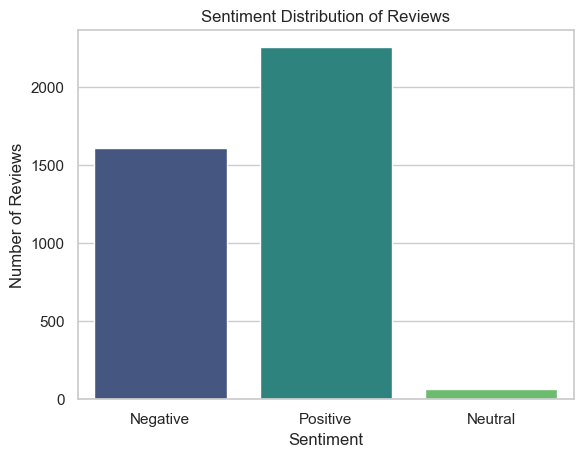

In [44]:
sns.countplot(data=df, x='sentiment_label', palette='viridis')
plt.title("Sentiment Distribution of Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

In [45]:
df['sentiment_score'].describe()

count    3925.000000
mean        0.159193
std         0.758213
min        -0.995500
25%        -0.700300
50%         0.421500
75%         0.913400
max         0.998200
Name: sentiment_score, dtype: float64

### Word Cloud

In [47]:
!pip install wordcloud
from wordcloud import WordCloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/fa/5f/34a0c0be52dc95f96aa1197f03ad5d5c58a9901c74f050d21a3e1b21ebf9/wordcloud-1.9.4-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 5.1 MB/s eta 0:00:00


In [50]:
comments_joined = " ".join(comment for comment in df.spacy_comment)

In [53]:
word_cloud = WordCloud(collocations = False, background_color = 'white',
                        width = 2048, height = 1080).generate(comments_joined)
# saving the image
word_cloud.to_file('review_wordcloud.png')

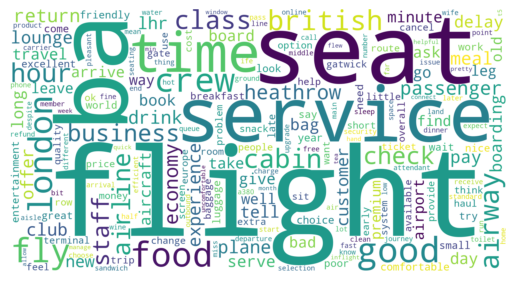

In [54]:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()